# Horizon Extension model
In this notebook we will go through the horizon extension task.

## Contents
* [Task description](#Task-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further-development)


# Task description
The goal of this notebook is to train a model to *segment a specific horizon* and solve the task of *horizon-extension*. In order to solve this task, prediction-time, we provide our model with 1) *ilines* of a seismic cube and 2) small part of a chosen horizon.

The motivation for this setup goes as follows: the creation of a "smart" autocorrelator based on neural networks. In a real-life scenario, a seismic geophysicist marks part of a horizon of interest and then runs autocorrelation software (for instance, [Petrel](https://www.software.slb.com/)) to extend this horizon. However, the autocorrelation software can easily break down on complex parts of seismic cubes, for instance, on faults or salt domes:

<img src="images/sault_dome.jpg" alt="Drawing" style="width: 500px;"/>

This behavior comes as no surprise. The autocorrelator is based on correlations between adjacent seismic traces and stops working properly in steep segments of horizons. On the contrary, convolutional neural networks are more sophisticated and should be able to extend a horizon through complex parts of cubes.

**Note**: Compare this task to the task of [horizon-detection](https://github.com/analysiscenter/seismiqb/blob/models/Horizons_detection.ipynb). Prediction-time, *detection model sees only ilines from seismic cubes*. Hence, it does not distinguish different horizons and attempts to detect all of them. On the contrary, during prediction-stage *extension model sees also a part of a target-horizon*. As a result, we can ask an extension model to *detect a specific horizon*.

In [1]:
# Set the number of GPU-device
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [2]:
# Necessary imports
%load_ext autoreload
%autoreload 2
import os
import sys
import logging

import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

sys.path.append('..')
from seismiqb.batchflow import Dataset, Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, L, F, D, P, R
from seismiqb.batchflow.models.tf import DenseNetFC
from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset
from utils import make_data_extension, predictions, show_input_data, show_extension_results

from glob import glob
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Dataset

For training we use multiple seismic cubes to prevent overfitting on amplitude values of a specific seismic cube.

We train the model on two cubes: `CUBE_3`, `CUBE_VUONGMK` and test on the third cube `CUBE_1`. A detailed description of each cube, including sample images, is available [here](../datasets/). For now, it is suffice to say that `CUBE_3` and `CUBE_1` are "simple" while `CUBE_VUONGMK` is "difficult" in terms of interpretation complexity.

**Note**: seismic cube is a 3d entity about 1000 points in each dimension, it *can never be fed to a GPU-memory entirely*. Therefore we train our models on crops of smaller shape. To do so we sample random positions in the cubes to take a crop from. Note that different proportions of sampled points are applied to each cube: approximately 80% of crops come from the `CUBE_VUONGMK`, 20% from the `CUBE_3`.

* set paths to seismic cubes and horizon-labels:

In [3]:
%%time
path_data_0 = '/notebooks/SEISMIC_DATA/CUBE_1/E_anon.hdf5'
path_data_1 = '/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5'
path_data_2 = '/notebooks/SEISMIC_DATA/CUBE_VUONGMK/Repaired_cube.hdf5'

save_dir = '/notebooks/SEISMIC_DATA/SAVED/ANEW/'
path_pc_saved = save_dir + 'point_clouds.dill'   # path_data: point_clouds

dsi = FilesIndex(path=[path_data_0, path_data_1, path_data_2], no_ext=True)
ds = SeismicCubeset(dsi)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 690 µs


* load info about cubes for fast preprocessing later

In [4]:
%time
ds = (ds.load_geometries()
        .load_point_clouds(path=path_pc_saved)
        .load_labels()
        .load_samplers(p=[0.00001, 0.2, 0.8])
      )

# ~80 seconds

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs


* set up logger for writing out progress about training

In [5]:
path_to_log = '/notebooks/darima/LOGS/DENSE.log'
handler = logging.FileHandler(path_to_log, mode='w')        
handler.setFormatter(logging.Formatter('%(asctime)s      %(message)s'))

train_logger = logging.getLogger('train_logger')
train_logger.setLevel(logging.INFO)
train_logger.addHandler(handler)
train_logger.info('Start new_train')

# Model architecture

For proof-of-concept demonstration **we will train two models**: 1) horizon extension model with a prior mask as an additional input to the model and 2) a standard [horizon detection model](https://github.com/analysiscenter/seismiqb/blob/models/Horizons_detection.ipynb) with the same architecture that we will use as a baseline.

We work with [FC-DenseNet](https://arxiv.org/abs/1611.09326) architecture with 5 dense blocks in encoder. Each block consists of 4 convolutional layers and has `growth_rate = 8` (number of feature maps in the output of each convolutional layer).

We will train both models on 3d crops with size (64, 64, 2) but use 2d convolutions providing third dimension of an input tensor as channel dimension.

For the horizon extension model we take a crop and corresponding target mask, zero-out target mask except for a small part of it and feed to the model a concatenation of crop and thin-out mask.

* set up shapes needed for extension and detection-models

In [5]:
NUM_CROPS = 64
CROP_SHAPE = [2, 64, 64]                                       # i, x, h

# create shape constants for model input and output
MODEL_SHAPE = [CROP_SHAPE[i] for i in(1, 2, 0)]               # x, h, i
MODEL_SHAPE_DICE = tuple(MODEL_SHAPE + [1])
INPUT_SHAPE_EXT = MODEL_SHAPE[:2] + [MODEL_SHAPE[-1] * 2]

* Define configuration-dictionaries for both models

In [ ]:
model_config_dense = {'initial_block/inputs': 'cubes',
                      'body': {'num_layers': [4]*5,
                               'block/growth_rate': 8, 'block/skip': True},
                      'loss': 'dice',
                      'optimizer': 'Adam',
                      'predictions': predictions,
                      'output': 'sigmoid',
                      'common': {'data_format': 'channels_last'}}

model_config_ext = {'inputs': dict(cubes={'shape': INPUT_SHAPE_EXT},
                                   masks={'name': 'targets', 'shape': MODEL_SHAPE_DICE}),
                    **model_config_dense}

model_config_base = {'inputs': dict(cubes={'shape': MODEL_SHAPE},
                                   masks={'name': 'targets', 'shape': MODEL_SHAPE_DICE}),
                    **model_config_dense}

In the next section we set up a [pipeline](): a sequence of actions we want to perform on data. It consists of three parts:
* `preprocessing`-part, that loads data, masks and samples crops for training
* `augmentation`-part with a couple of augmentations including random `rotate` and `scale` to prevent overfitting
* `training`-part that trains both models under the same conditions in the sense of data fed to the model.

Define load pipeline that samples random crop positions in the first 80 % of the cubes, loads crops from seismic cubes, applies min-max scaling, creates masks and transposes data so the last axis has the smaller size.

In [8]:
preprocessing = (Pipeline()
                 .load_component(src=[D('geometries'), D('labels')],
                                 dst=['geometries', 'labels'])
                 .crop(points=L(ds.sampler.truncate(high=0.8, expr=lambda p: p[:, 1]).sample,
                                NUM_CROPS), shape=CROP_SHAPE)
                 .load_cubes(dst='data_crops')
                 .create_masks(dst='mask_crops', width=2, single_horizon=True)
                 .rotate_axes(src=['data_crops', 'mask_crops'])
                 .scale(mode='normalize', src='data_crops'))

* Add to `preprocessing` action `filter_out` that thins out the horizon-mask and puts it into `cut_mask_crops`-component.

In [9]:
preprocessing += (Pipeline().filter_out(src='mask_crops', dst='cut_mask_crops',
                                         expr=lambda m: m[:, 0],
                                         low=R('uniform', low=0.3,high=0.4),
                                         high=R('uniform', low=0.40, high=0.45)))

Let's have a look on the input data, target mask and thin-out mask.

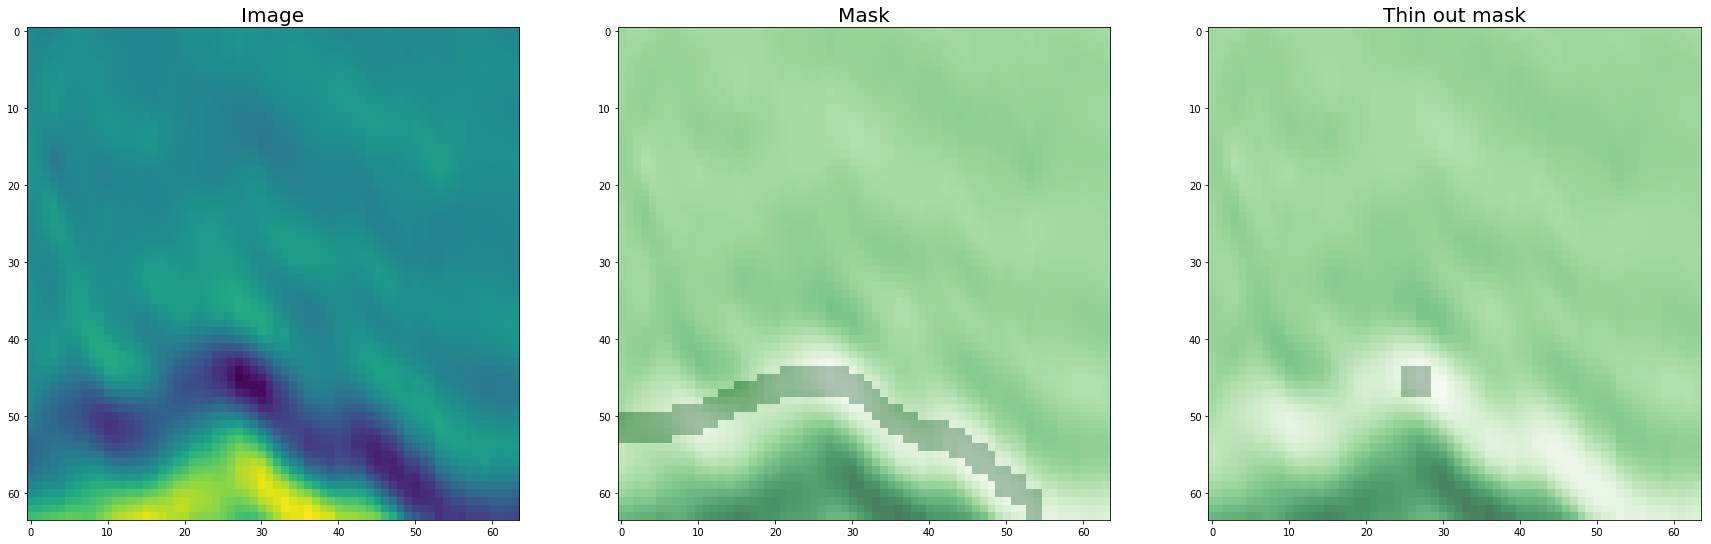

In [12]:
show_ppl = preprocessing << ds
btch = show_ppl.next_batch(3)
show_input_data(btch)

Define adugment_ppl that adds some random augmentations. 

In [10]:
augment_ppl = (Pipeline()
               .additive_noise(scale=0.005, src='data_crops', dst='data_crops', p=0.2)
               .rotate(angle=P(R('uniform', -30, 30)),
                       src=['data_crops', 'mask_crops', 'cut_mask_crops'], p=0.4)
               .scale_2d(scale=P(R('uniform', 0.7, 1.3)),
                         src=['data_crops', 'mask_crops', 'cut_mask_crops'], p=0.4)
               .cutout_2d(patch_shape=P(R('uniform', 5, 15, size=2)),
                          n=P(R('uniform', 3, 7)), src='data_crops')
               .elastic_transform(alpha=P(R('uniform', 35, 45)),
                                  sigma=P(R('uniform', 4, 4.5)),
                                  src=['data_crops', 'mask_crops', 'cut_mask_crops'], p=0.2))

Train_pipeline for both models. 
For the 'extension' model we concatenate seismic data and thin-out mask along the last axis. Creation of the feed dict is define in [make_data_extension](./utils.py).

For the 'baseline' horizon detection model we use the same architecture and train the model providing it with seismic data only.

In [11]:
train_pipeline = ((preprocessing + augment_ppl)
                  .add_axis(src='mask_crops', dst='mask_crops')
                  .init_variables(dict(loss_history=dict(init_on_each_run=list),
                                       current_loss=dict(init_on_each_run=0),
                                       ext_loss_history=dict(init_on_each_run=list),
                                       ext_current_loss=dict(init_on_each_run=0)))
                  .init_model('dynamic', DenseNetFC, 'base', model_config_base)
                  .train_model('base',
                               fetches='loss', make_data={'cubes': B('data_crops'),
                                                          'masks': B('mask_crops')},
                               save_to=V('current_loss'))
                  .update_variable('loss_history',
                                   V('current_loss'),
                                   mode='a')
                  .init_model('dynamic', DenseNetFC, 'extension', model_config_ext)
                  .train_model('extension',
                               fetches='loss',
                               make_data=make_data_extension,
                               save_to=V('ext_current_loss'),
                               use_lock=True)
                  .update_variable('ext_loss_history', V('ext_current_loss'), mode='a')) << ds

loss_history = []

# Training

As it was defined in the model config we will train model with Adam optimizer with defult hyperparameters on the crops of fixed size.

We will train for 2000 iterations with batch_size=64.

In [97]:
epochs = 2000

with tqdm(total=epochs, smoothing=0.2) as pbar:
    for e in range(1, epochs+1):
        train_batch = train_pipeline.next_batch(3, n_epochs=None)
        current_loss = train_pipeline.get_variable("current_loss")

        train_logger.info('Epoch: {:>4};  Loss is: {:.7}'.format(e, current_loss))
        loss_history.append(current_loss)

        pbar.set_description('Loss:{:12.7}'.format(current_loss))
        pbar.update(1)

  0%|          | 0/2000 [00:00<?, ?it/s]

in output  1 predictions  <function predictions at 0x7f541bcc7f28>
in output  1 predictions  <function predictions at 0x7f541bcc7f28>


Loss:  -0.9045113: 100%|██████████| 2000/2000 [3:23:25<00:00,  5.13s/it]


In [27]:
plt.figure(figsize=(10,10)

plt.plot(loss_history)
plt.plot(train_pipeline.get_variable('ext_loss_history'), c='g')
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.grid(True)
plt.ylim((-1.2,0))
plt.title('DenseNet')
plt.show()

# Inference

In this part we will take a look at the segmentation results of our models on two types of data:
    1. the rest 20% of the CUBE_3 and CUBE_VUONGMK cubes that we didn't use during the training.
    2. Cube_1 that wasn't used in the training.
    
After that we will [assemble predictions on a grid of crops](#In-the-big-picture) and see the segmentation results on a big slide.

1. Load the unseen part of the cubes used in training:

In [100]:
test_load_ppl = (Pipeline()
                    .load_component(src=[D('geometries'), D('labels')],
                                  dst=['geometries', 'labels'])
                    .crop(points=L(ds.sampler.truncate(low=0.7, expr=lambda p: p[:, 1]).sample,
                                   NUM_CROPS), shape=CROP_SHAPE)
                    .load_cubes(dst='data_crops')
                    .create_masks(dst='mask_crops', width=2, max_horizons=1)
                    .rotate_axes(src=['data_crops', 'mask_crops'])
                    .scale(mode='normalize', src='data_crops'))

In [101]:
val_pipeline = ((test_load_ppl + filter_mask_ppl)
                 .add_axis(src='mask_crops', dst='mask_crops')
                 .import_model('base', train_pipeline)
                 .init_variable('result', init_on_each_run=list())
                 .predict_model('base',
                                fetches=['cubes', 'masks', 'predictions', 'loss'],
                                make_data={'cubes': B('data_crops'), 'masks': B('mask_crops')},
                                save_to=V('result'), mode='a')
                 .import_model('extension', train_pipeline)
                 .init_variable('ext_result', init_on_each_run=list())
                 .predict_model('extension',
                                fetches=['cubes', 'masks', 'predictions', 'loss'],
                                make_data=make_data_extension,
                                save_to=V('ext_result'), mode='a')
                 ) << ds

In [102]:
val_batch = val_pipeline.next_batch(3, n_epochs=None)

In [103]:
cubes_numbers = np.random.choice(NUM_CROPS, 4)

Show the results of segmentation for extension model (column 4) and baseline horizon detection model (column 5)

Loss is:  -0.6520593
P_cube


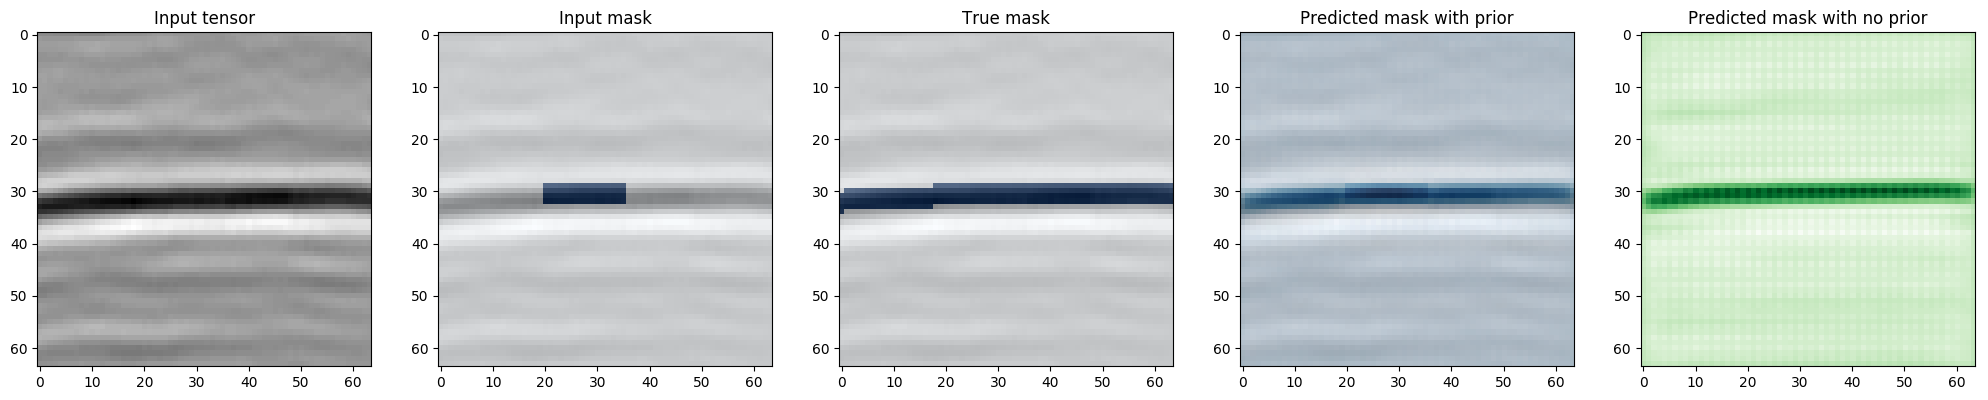

P_cube


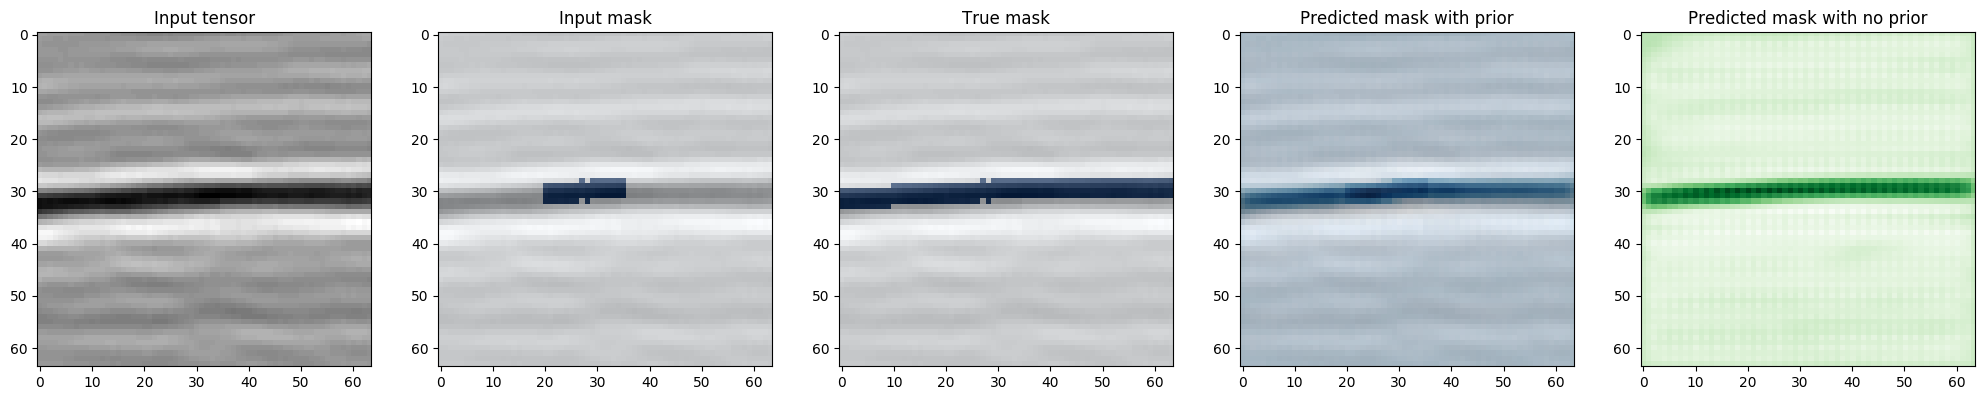

Repaired_cube


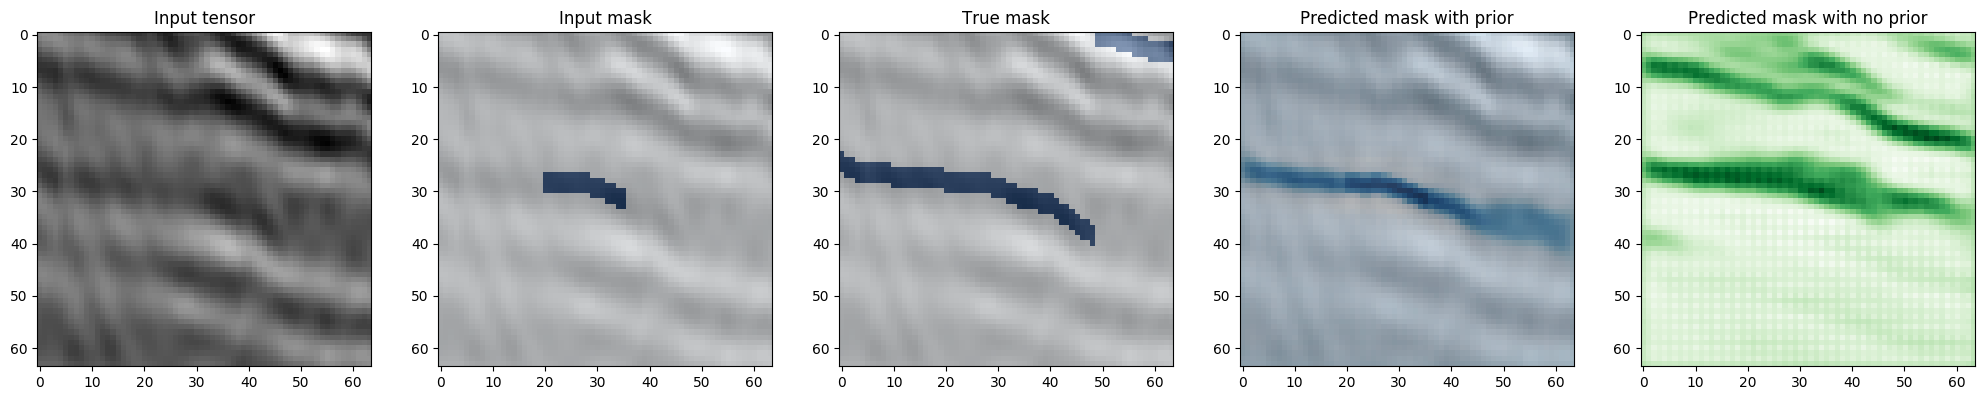

Repaired_cube


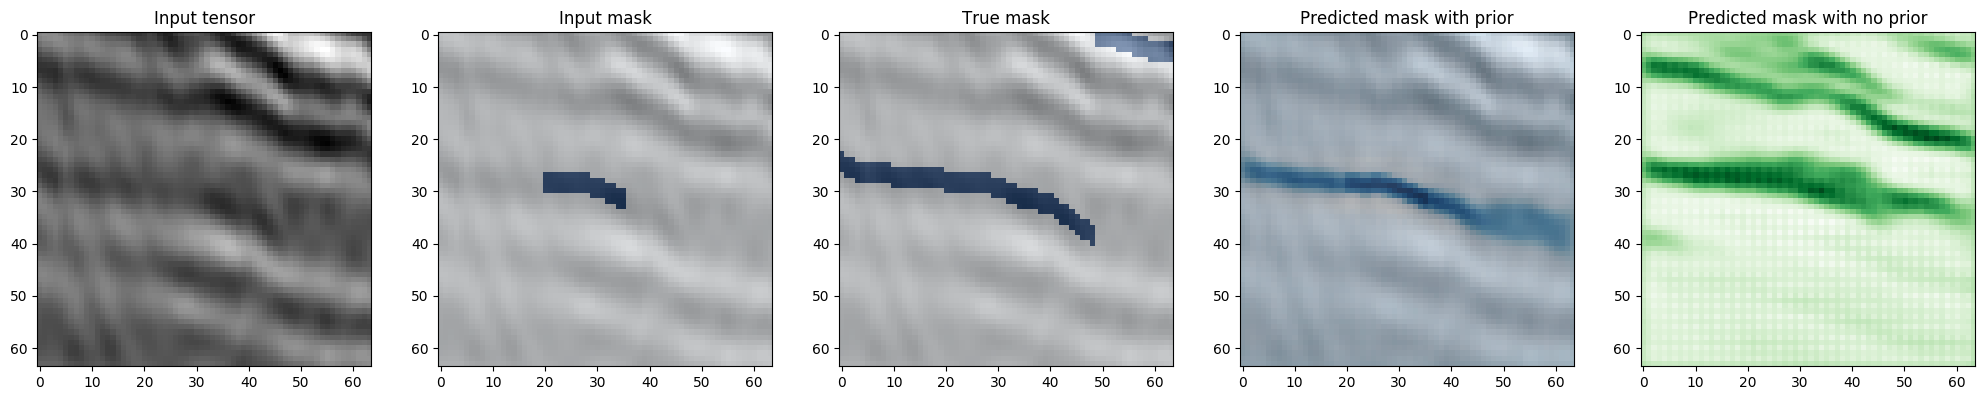

In [105]:
print('Loss is: ', val_pipeline.get_variable('result')[0][3])
show_extension_results(val_batch, val_pipeline, cubes_numbers)

2. Load Cube_1 that wasn't used during the training.

In [106]:
path_data_0 = '/notebooks/SEISMIC_DATA/CUBE_1/E_anon.hdf5'
save_dir = '/notebooks/darima/SAVED_MASTER/SAVED_CUBE_1/'

test_geom_saved =     save_dir + 'geometries.dill'
test_pc_saved =       save_dir + 'point_clouds.dill'
test_labels_saved =   save_dir + 'labels.dill'
test_samplers_saved = save_dir + 'samplers.dill'

In [107]:
test_dsi = FilesIndex(path=[path_data_0], no_ext=True)
test_ds = SeismicCubeset(test_dsi)

In [108]:
test_ds = (test_ds.load_geometries()
              .load_point_clouds(path = path_pc_saved)
              .load_labels()
              .load_samplers()
           )

In [110]:
new_test_load_ppl = (Pipeline()
                    .load_component(src=[D('geometries'), D('labels')],
                                  dst=['geometries', 'labels'])
                    .crop(points=L(test_ds.sampler.truncate(high=1.0, expr=lambda p: p[:, 1]).sample,
                                   NUM_CROPS), shape=CROP_SHAPE)
                    .load_cubes(dst='data_crops')
                    .create_masks(dst='mask_crops', width=2, max_horizons=1)
                    .rotate_axes(src=['data_crops', 'mask_crops'])
                    .scale(mode='normalize', src='data_crops'))

In [111]:
new_test_ppl = (Pipeline()                 
                  .add_axis(src='mask_crops', dst='mask_crops')
                  .import_model('base', train_pipeline)
                  .init_variable('result', init_on_each_run=list())
                  .predict_model('base',
                                 fetches=['cubes', 'masks', 'predictions', 'loss'],
                                 make_data={'cubes': B('data_crops'), 'masks': B('mask_crops')},
                                 save_to=V('result'), mode='a')
                  .import_model('extension', train_pipeline)
                  .init_variable('ext_result', init_on_each_run=list())
                  .predict_model('extension',
                                 fetches=['cubes', 'masks', 'predictions', 'loss'],
                                 make_data=make_data_extension,
                                 save_to=V('ext_result'), mode='a')
                  )

In [112]:
test_on_third_ppl = (new_test_load_ppl + filter_mask_ppl + new_test_ppl) << test_ds

In [113]:
btch = test_on_third_ppl.next_batch(3, n_epochs=None)

Show the results:

Loss is:  -0.09915118
E_anon


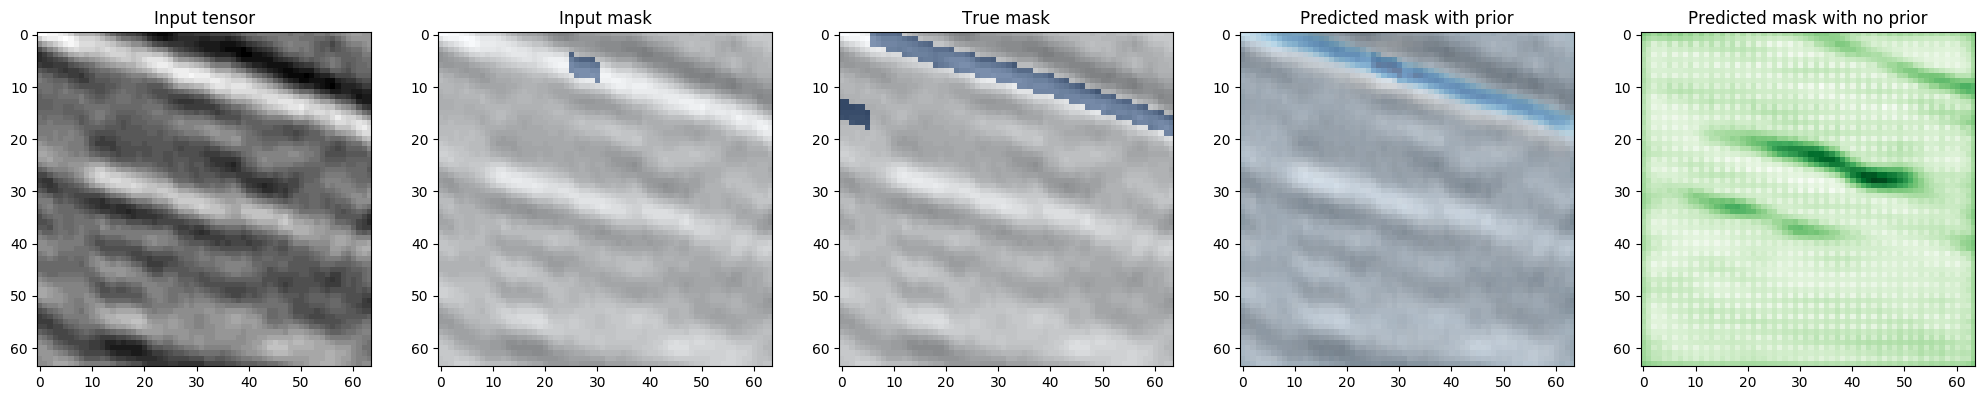

E_anon


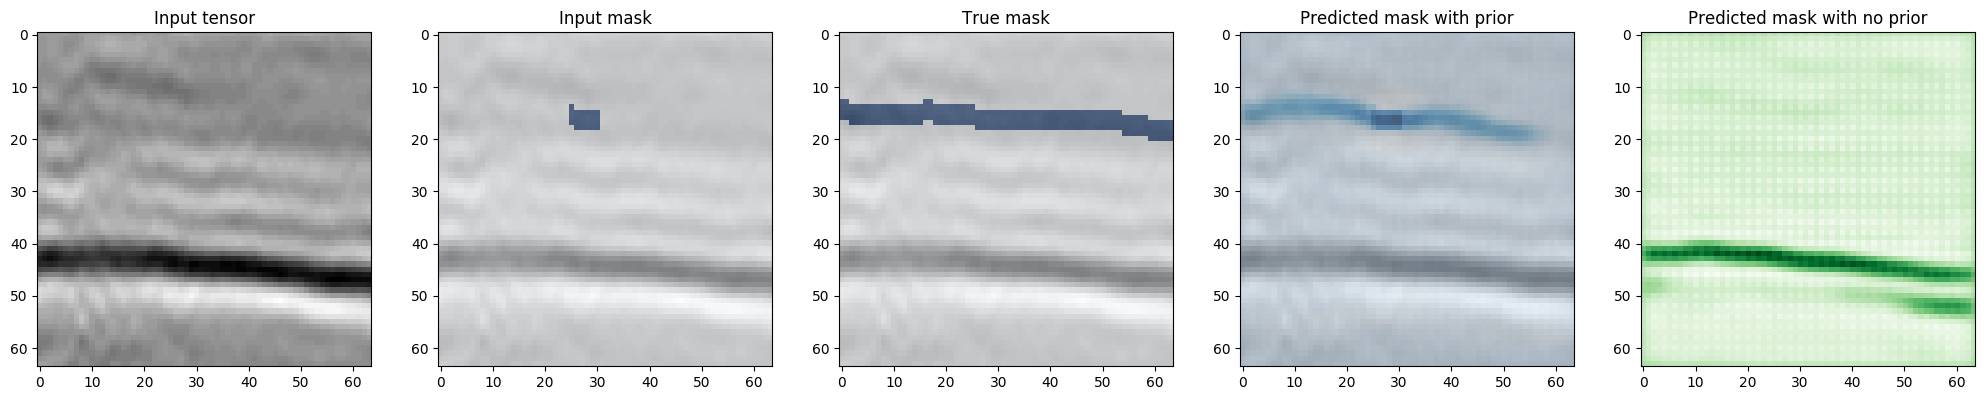

E_anon


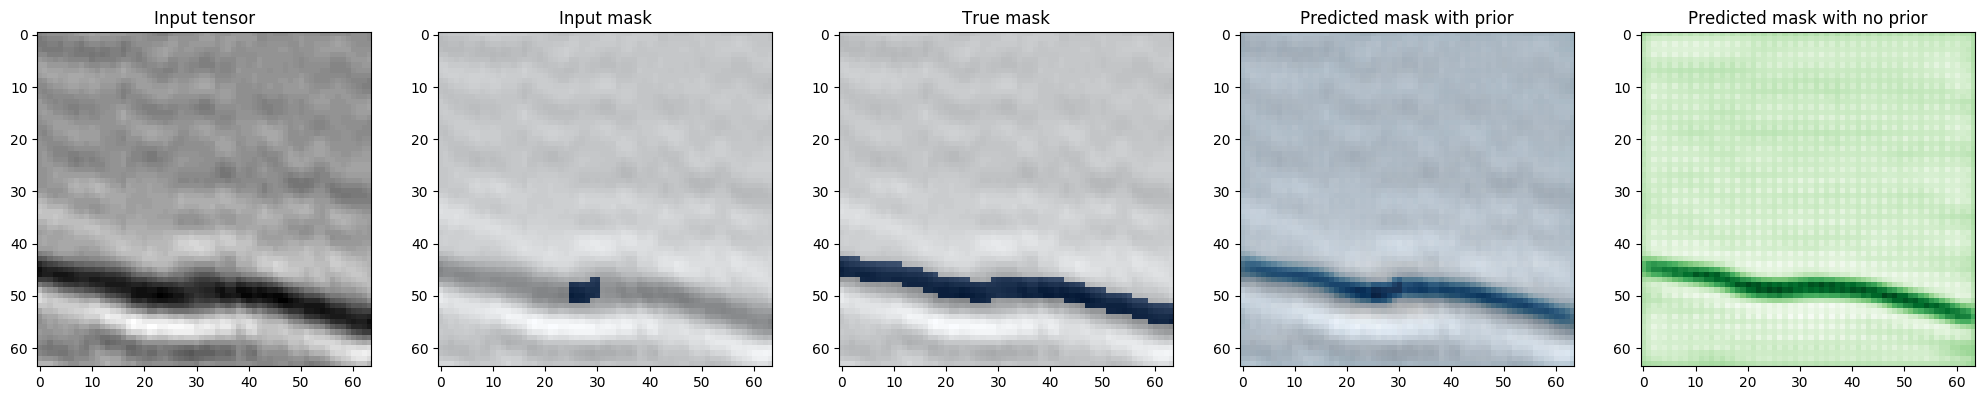

E_anon


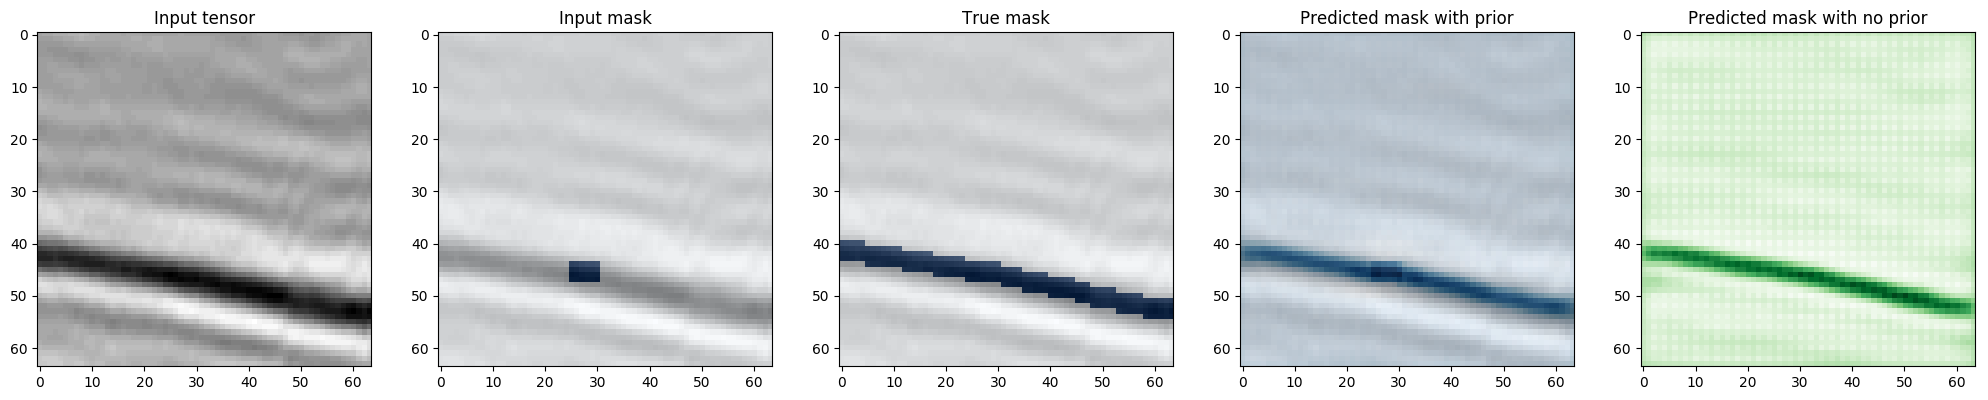

In [117]:
print('Loss is: ', test_on_third_ppl.get_variable('result')[0][3])
show_extension_results(btch, test_on_third_ppl, cubes_numbers)

# In the big picture

Here we assemble predictions on a grid of crops to see the results on the whole slice of the cube.

In [115]:
%%time
test_ds = test_ds.make_grid(test_ds.indices[0], CROP_SHAPE,
                            [1000, 1001], [400, 1200], [100, 1300],
                            strides=[1, 32, 32])

print('Shape of grid:', test_ds.grid_info['grid_array'].shape)

pred_pipeline = (Pipeline()
                 .load_component(src=[D('geometries'), D('labels')],
                                 dst=['geometries', 'labels'])
                 .crop(points=L(D('grid_gen')),
                       shape=CROP_SHAPE)
                 .load_cubes(dst='data_crops')
                 .create_masks(dst='mask_crops')
                 .rotate_axes(src=['data_crops', 'mask_crops'])
                 .scale(mode='normalize', src='data_crops')
                 .filter_out(src='mask_crops', dst='cut_mask_crops', expr=lambda m: m[:, 0],
                             low=R('uniform', low=0.3, high=0.4), high=R('uniform', low=0.45, high=0.6))
                 .add_axis(src='mask_crops', dst='mask_crops')
                 .import_model('base', train_pipeline)
                 .init_variable('result_cubes', init_on_each_run=list())
                 .init_variable('result_masks', init_on_each_run=list())
                 .init_variable('result_preds', init_on_each_run=list())
                 .predict_model('base',
                                fetches=['cubes', 'masks', 'predictions'],
                                make_data={'cubes': B('data_crops'), 'masks': B('mask_crops')}, 
                                save_to=[V('result_cubes'), V('result_masks'), V('result_preds')], mode='e')
                 .assemble_crops(src=V('result_cubes'), dst='assembled_cube',
                                   grid_info=D('grid_info'), mode='avg')
                 .assemble_crops(src=V('result_masks'), dst='assembled_mask',
                                   grid_info=D('grid_info'), mode='avg')
                 .assemble_crops(src=V('result_preds'), dst='assembled_pred',
                                   grid_info=D('grid_info'), mode='max')
                 .import_model('extension', train_pipeline)
                 .init_variable('extension_result_cubes', init_on_each_run=list())
                 .init_variable('extension_result_preds', init_on_each_run=list())
                 .predict_model('extension', 
                                fetches=['cubes', 'predictions'],
                                make_data=make_data_extension,
                                save_to=[V('extension_result_cubes'),
                                         V('extension_result_preds')], mode='e')
                 .assemble_crops(src=V('extension_result_cubes'), dst='extension_assembled_cubes',
                                 grid_info=D('grid_info'), mode='avg')
                 .assemble_crops(src=V('extension_result_preds'), dst='extension_assembled_pred',
                                 grid_info=D('grid_info'), mode='max')
                 ) << test_ds

for _ in range(test_ds.grid_iters):
    pred_batch = pred_pipeline.next_batch(1, n_epochs=None)

Shape of grid: (1976, 3)
CPU times: user 2min 11s, sys: 17.3 s, total: 2min 28s
Wall time: 2min 26s


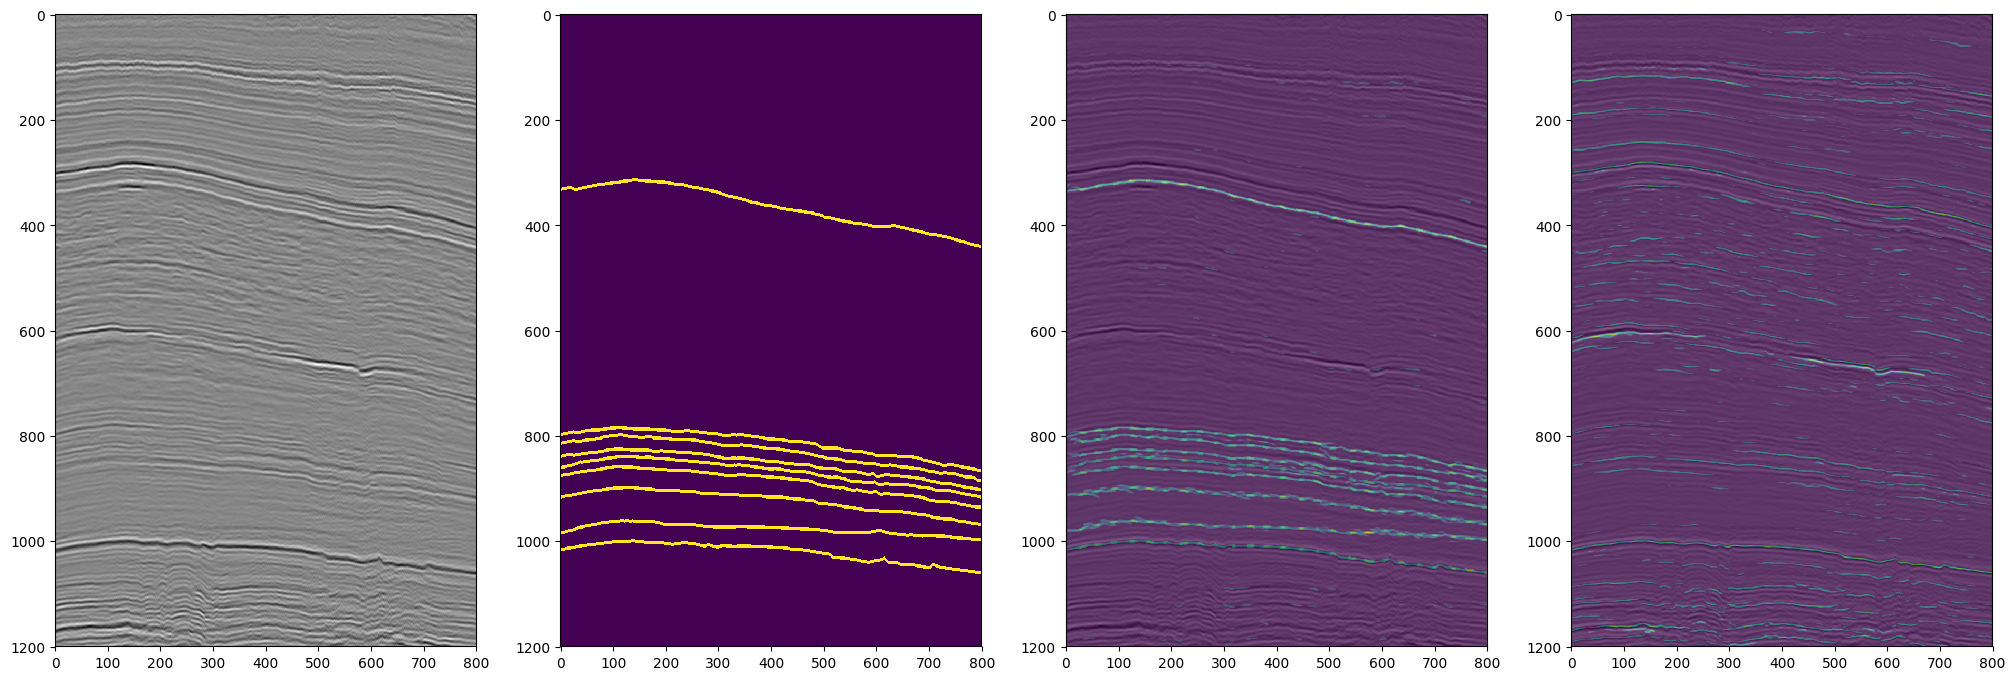

In [116]:
img_full = pred_batch.assembled_cube
mask_full = pred_batch.assembled_mask


pred_full_base = pred_batch.assembled_pred

cut_mask_full = pred_batch.extension_assembled_cubes
pred_full = pred_batch.extension_assembled_pred


iline = 0

fig, ax = plt.subplots(1, 4, figsize=(25, 25))

ax[0].imshow(img_full[iline, :, :].T, cmap='gray')

ax[1].imshow(mask_full[iline, :, :].T)

# ax[1].imshow(img_full[iline, :, :].T, vmin=0.5, vmax=0.6, cmap='gray', alpha=0.99)
ax[2].imshow(pred_full[iline, :, :].T)
ax[2].imshow(img_full[iline, :, :].T, cmap='gray', alpha=0.4)

ax[3].imshow(pred_full_base[iline, :, :].T)
ax[3].imshow(img_full[iline, :, :].T, cmap='gray', alpha=0.4)


plt.show()

# Proposals for the improvement and further development

Now we see 2 main issue to be solved:
    1. Lack of the quantity metrics for model performance evaluation.
    2. Computing predictions on a grid we use a part of the true target mask as input for the model. Instead, model should use prediction of joint crop as a prior mask.
    3. FC-Densenet is quite big model and must be modified.